#  Taylorjev razvoj

## Navodilo naloge

S Taylorjevim razvojem izračunaj funkciji $exp(A)$ in $exp(iA)$, kjer je matrika 

$$A =
\begin{bmatrix}
1 & 1 \\
1 & −1\end{bmatrix}$$

Kako lastne vrednosti približkov n-tega reda konvergirajo k točnemu rezultatu?

## Teorija na kratko

Taylorjev razvoj za eksponentno funkcijo se glasi:

$$ e^X = \sum_{n=0}^\infty \frac{1}{n!} X^n $$

kjer je X poljubna matrika (poseben primer je matrika velikosti 1x1, kjer dobimo Taylorjev razvoj za skalar, tj. neko kompleksno število).

Poseben primer so diagonalne matrike. Če je matrika $A$ diagonalna, tj. $A_{ij} = 0$ za $i \neq j$, je $(e^A)_{ii} = e^{A_{ii}}$. To lahko izkoristimo tako, da matriko diagonaliziramo in upoštevamo zvezo:

$$ e^{A} = e^{PDP^{-1}} = P e^{D} P^{-1} $$

Ker potrebujemo točen rezultat lastnih vrednosti za primerjavo s približki, je najbolje, da to kar takoj izračunamo. Poleg tega izračunamo še celoten eksponent matrike $A$, da lahko gledamo kako se tudi te približki približujejo.

Za prvi del bomo gledali kako se lastne vrednosti približkov približujejo dejanskim lastnim vredostim $e^A$, kasneje pa še za matriko $e^{iA}$.

## $$e^A$$

In [1]:
import numpy as np
from scipy.linalg import expm

A = np.array([[1,1],[1,-1]])
eigenvalues = np.linalg.eigvals(A)

# lastne vrednosti eksponente matrike so kar eksponenti lastnih vrednosti
eigenvalues = np.exp(eigenvalues)
print(f'Eigenvalues of exp(A): {eigenvalues}')

# izracunamo se eksponent matrike
exp_A = expm(A)
print(f'exp(A):')
print(exp_A)

Eigenvalues of exp(A): [4.11325038 0.24311673]
exp(A):
[[3.54648243 1.36829887]
 [1.36829887 0.80988468]]


### Pomožne funkcije

Definirajmo pomožne funkcije za izračun približkov.

In [2]:
from diskcache import Cache

cache = Cache('.cache')

@cache.memoize(typed=False, expire=420, tag='factorial')
def factorial(n: int) -> int:
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


@cache.memoize(typed=False, expire=420, tag='matrix_pow')
def matrix_pow(M: np.ndarray, n: int) -> np.ndarray:
    if n == 0:
        return np.eye(M.shape[0])
    else:
        return M @ matrix_pow(M, n-1)


@cache.memoize(typed=False, expire=420, tag='matrix_exp')
def matrix_exp(M: np.ndarray, n: int) -> np.ndarray:
    if n == 0:
        return matrix_pow(M, 0)
    else:
        return matrix_exp(M, n-1) + matrix_pow(M, n) / factorial(n)

### Glavna zanka

Vsako iteracijo izračunamo približke kot povedano zgoraj v teoriji. Rezultate si shranimo; spodaj je tabeliran prikaz in izrisan graf

In [3]:
# nastavimo zastavice za najvecje stevilo iteracij in za najvecjo toleranco
MAX_ITERATIONS = 100
# osnova zaokrozitvena napaka na 64-bitnem racunalniku je 16 bitov, zato nima smisla racunati na vec decimalnih mest kot to
THRESHOLD = 1e-15

# hranimo priblizke za l.v., da jih lahko kasneje izpisemo
first_eigenvalues = []
second_eigenvalues = []

# sproti racunamo tudi njihove napake. vzamemo kar absoultno vrednost
first_eigenvalue_error = []
second_eigenvalue_error = []

# sicer nepotrebno, ampak spremljamo tudi kako hitro se matrike priblizkov priblizujejo resitvi
# uporabimo tudi kot zaostavitveni pogoj, tj. ko je frobeniusova norma manjsa od THRESHOLD, prekinemo z iteracijami
fro_norm_error = []
inf_norm_error = []
first_norm_error = []

for n in range(MAX_ITERATIONS):
    exp_An = matrix_exp(A, n)
    
    # izracunamo norme
    fro_norm = np.linalg.norm(exp_An - exp_A, ord='fro')
    inf_norm = np.linalg.norm(exp_An - exp_A, ord=np.inf)
    first_norm = np.linalg.norm(exp_An - exp_A, ord=1)
    
    if fro_norm < THRESHOLD:
        break
    
    fro_norm_error.append(fro_norm)
    inf_norm_error.append(inf_norm)
    first_norm_error.append(first_norm)
    
    eigenvalues_approx = np.linalg.eigvals(exp_An)
    
    first_eigenvalues.append(eigenvalues_approx[0])
    second_eigenvalues.append(eigenvalues_approx[1])
    
    # napake priblizkov l.v.
    e1 = np.abs(eigenvalues[0] - eigenvalues_approx[0])
    e2 = np.abs(eigenvalues[1] - eigenvalues_approx[1])
    
    first_eigenvalue_error.append(e1)
    second_eigenvalue_error.append(e2)

### Tabeliran prikaz približkov lastnih vrednosti

In [4]:
from tabulate import tabulate

n = len(first_eigenvalues)
eig_results = np.array([np.arange(n).astype(str), eigenvalues[0]*np.ones(n), first_eigenvalues, first_eigenvalue_error, eigenvalues[1]*np.ones(n), second_eigenvalues, second_eigenvalue_error]).T
table = tabulate(eig_results, headers=['Iteration', 'First eigenvalue', 'First eigenvalue approximation', 'First eigenvalue error', 'Second eigenvalue', 'Second eigenvalue approximation', 'Second eigenvalue error'], tablefmt='psql', floatfmt='.16f')
print(table)

+-------------+--------------------+----------------------------------+--------------------------+---------------------+-----------------------------------+---------------------------+
|   Iteration |   First eigenvalue |   First eigenvalue approximation |   First eigenvalue error |   Second eigenvalue |   Second eigenvalue approximation |   Second eigenvalue error |
|-------------+--------------------+----------------------------------+--------------------------+---------------------+-----------------------------------+---------------------------|
|           0 | 4.1132503787829267 |               1.0000000000000000 |       3.1132503787829267 |  0.2431167344342142 |                1.0000000000000000 |        0.7568832655657858 |
|           1 | 4.1132503787829267 |               2.4142135623730949 |       1.6990368164098317 |  0.2431167344342142 |               -0.4142135623730951 |        0.6573302968073093 |
|           2 | 4.1132503787829267 |               3.4142135623730949 |    

### Tabeliran prikaz vseh napak, lastnih vrednosti in norm matrike

In [5]:
from tabulate import tabulate

n = len(first_eigenvalues)
err_results = np.array([np.arange(n).astype(str), first_eigenvalue_error, second_eigenvalue_error, fro_norm_error, inf_norm_error, first_norm_error]).T
table = tabulate(err_results, headers=['Iteration', '1st eigenvalue error', '2nd eigenvalue error', 'Frobenius norm error', 'Inf norm error', 'First norm error'], tablefmt='psql', floatfmt='.16f')
print(table)

+-------------+------------------------+------------------------+------------------------+--------------------+--------------------+
|   Iteration |   1st eigenvalue error |   2nd eigenvalue error |   Frobenius norm error |     Inf norm error |   First norm error |
|-------------+------------------------+------------------------+------------------------+--------------------+--------------------|
|           0 |     3.1132503787829267 |     0.7568832655657858 |     3.2039351114973553 | 3.9147813006257524 | 3.9147813006257524 |
|           1 |     1.6990368164098317 |     0.6573302968073093 |     1.8217599245281590 | 1.9147813006257521 | 1.9147813006257521 |
|           2 |     0.6990368164098317 |     0.3426697031926906 |     0.7785081863298294 | 0.9147813006257521 | 0.9147813006257521 |
|           3 |     0.2276322956187995 |     0.1287348175983408 |     0.2615131263832911 | 0.2481146339590854 | 0.2481146339590854 |
|           4 |     0.0609656289521334 |     0.0379318490683258 |    

### Grafični prikaz napak

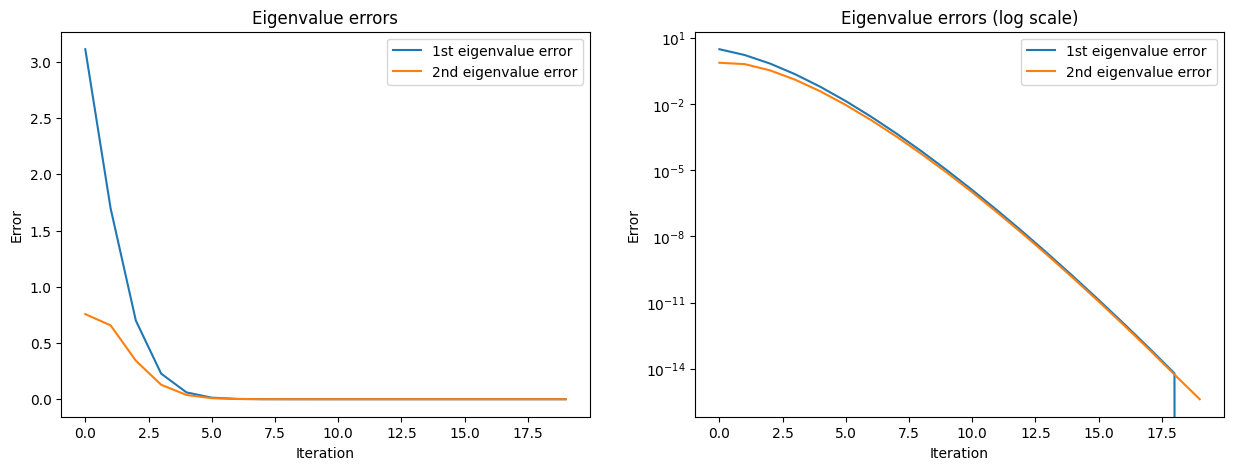

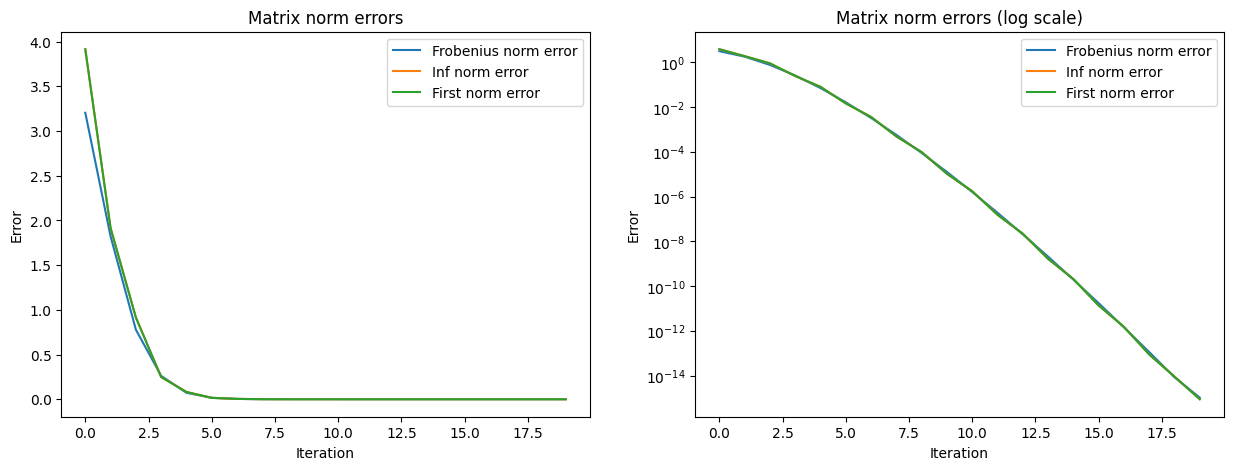

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1) # type: ignore
plt.plot(first_eigenvalue_error, label='1st eigenvalue error')
plt.plot(second_eigenvalue_error, label='2nd eigenvalue error')
plt.title('Eigenvalue errors')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')

fig.add_subplot(1, 2, 2) # type: ignore
plt.plot(first_eigenvalue_error, label='1st eigenvalue error')
plt.plot(second_eigenvalue_error, label='2nd eigenvalue error')
plt.title('Eigenvalue errors (log scale)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1) # type: ignore
plt.plot(fro_norm_error, label='Frobenius norm error')
plt.plot(inf_norm_error, label='Inf norm error')
plt.plot(first_norm_error, label='First norm error')
plt.legend()
plt.title('Matrix norm errors')
plt.xlabel('Iteration')
plt.ylabel('Error')

fig.add_subplot(1, 2, 2) # type: ignore
plt.plot(fro_norm_error, label='Frobenius norm error')
plt.plot(inf_norm_error, label='Inf norm error')
plt.plot(first_norm_error, label='First norm error')
plt.yscale('log')
plt.legend()
plt.title('Matrix norm errors (log scale)')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

## $$e^{iA}$$

In [7]:
import numpy as np
from scipy.linalg import expm

A = 1j * np.array([[1,1],[1,-1]])
eigenvalues = np.linalg.eigvals(A)
eigenvalues = np.exp(eigenvalues)
print(f'Eigenvalues of exp(A): {eigenvalues}')

exp_A = expm(A)
print(f'exp(A):')
print(exp_A)

Eigenvalues of exp(A): [0.15594369+0.98776595j 0.15594369-0.98776595j]
exp(A):
[[0.15594369+0.698456j 0.        +0.698456j]
 [0.        +0.698456j 0.15594369-0.698456j]]


### Glavna zanka

In [8]:
MAX_ITERATIONS = 100
THRESHOLD = 1e-15

first_eigenvalues = []
second_eigenvalues = []

first_eigenvalue_error = []
second_eigenvalue_error = []

fro_norm_error = []
inf_norm_error = []
first_norm_error = []

for n in range(MAX_ITERATIONS):
    exp_An = matrix_exp(A, n)
    
    fro_norm = np.linalg.norm(exp_An - exp_A, ord='fro')
    inf_norm = np.linalg.norm(exp_An - exp_A, ord=np.inf)
    first_norm = np.linalg.norm(exp_An - exp_A, ord=1)
    
    if fro_norm < THRESHOLD:
        break
    
    fro_norm_error.append(fro_norm)
    inf_norm_error.append(inf_norm)
    first_norm_error.append(first_norm)
    
    eigenvalues_approx = np.linalg.eigvals(exp_An)
    
    first_eigenvalues.append(eigenvalues_approx[0])
    second_eigenvalues.append(eigenvalues_approx[1])
    
    e1 = np.abs(eigenvalues[0] - eigenvalues_approx[0])
    e2 = np.abs(eigenvalues[1] - eigenvalues_approx[1])
    
    first_eigenvalue_error.append(e1)
    second_eigenvalue_error.append(e2)

### Tabeliran prikaz približkov lastnih vrednosti

In [9]:
from tabulate import tabulate

n = len(first_eigenvalues)
eig_results = np.array([np.arange(n).astype(str), (eigenvalues[0]*np.ones(n)).astype(str), np.array(first_eigenvalues).astype(str), first_eigenvalue_error, (eigenvalues[1]*np.ones(n)).astype(str), np.array(second_eigenvalues).astype(str), second_eigenvalue_error]).T
table = tabulate(eig_results, headers=['Iteration', '1st eigenvalue', '1st eigenvalue approx', '1st eigenvalue error', '2nd eigenvalue', '2nd eigenvalue approx', '2nd eigenvalue error'], tablefmt='psql', floatfmt='.16f')
print(table)

+-------------+------------------------------------------+-------------------------------------------+------------------------+------------------------------------------+-----------------------------------------------+------------------------+
|   Iteration | 1st eigenvalue                           | 1st eigenvalue approx                     |   1st eigenvalue error | 2nd eigenvalue                           | 2nd eigenvalue approx                         |   2nd eigenvalue error |
|-------------+------------------------------------------+-------------------------------------------+------------------------+------------------------------------------+-----------------------------------------------+------------------------|
|           0 | (0.1559436947653748+0.9877659459927355j) | (1+0j)                                    |     1.2992738781601245 | (0.1559436947653746-0.9877659459927355j) | (1+0j)                                        |     1.2992738781601247 |
|           1 | (0.15594

### Tabeliran prikaz vseh napak

In [10]:
from tabulate import tabulate

err_results = np.array([np.arange(len(first_eigenvalue_error)), first_eigenvalue_error, second_eigenvalue_error, fro_norm_error, inf_norm_error, first_norm_error]).T
table = tabulate(err_results, headers=['Iteration', '1st eigenvalue error', '2nd eigenvalue error', 'Frobenius norm error', 'Inf norm error', 'First norm error'], tablefmt='psql')
print(table)

+-------------+------------------------+------------------------+------------------------+------------------+--------------------+
|   Iteration |   1st eigenvalue error |   2nd eigenvalue error |   Frobenius norm error |   Inf norm error |   First norm error |
|-------------+------------------------+------------------------+------------------------+------------------+--------------------|
|           0 |            1.29927     |            1.29927     |            1.83745     |      1.79403     |        1.79403     |
|           1 |            0.945668    |            0.945668    |            1.33738     |      1.19785     |        1.19785     |
|           2 |            0.454066    |            0.454066    |            0.642146    |      0.641025    |        0.641025    |
|           3 |            0.162295    |            0.162295    |            0.229519    |      0.19094     |        0.19094     |
|           4 |            0.046218    |            0.046218    |            0.0653

### Grafični prikaz napak

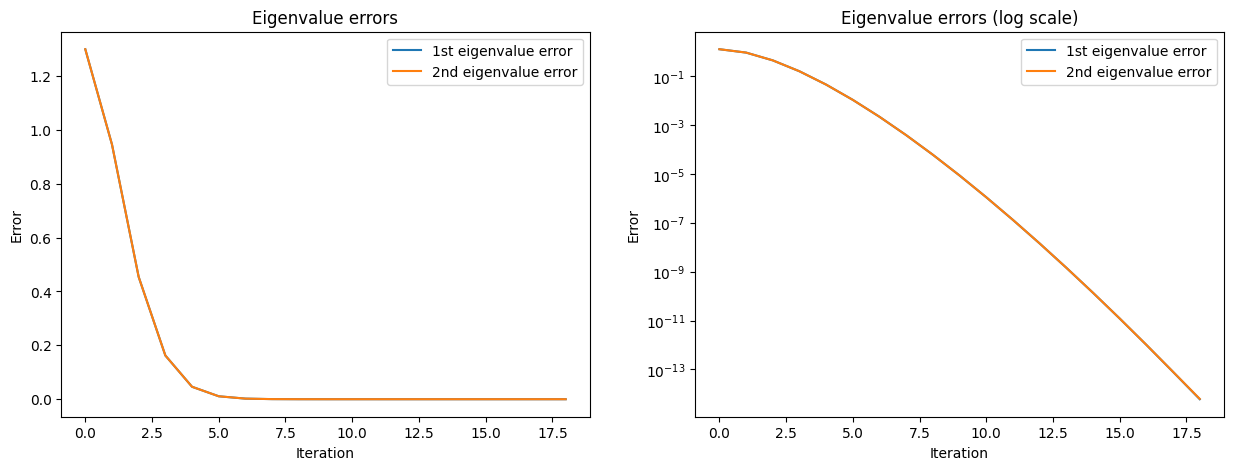

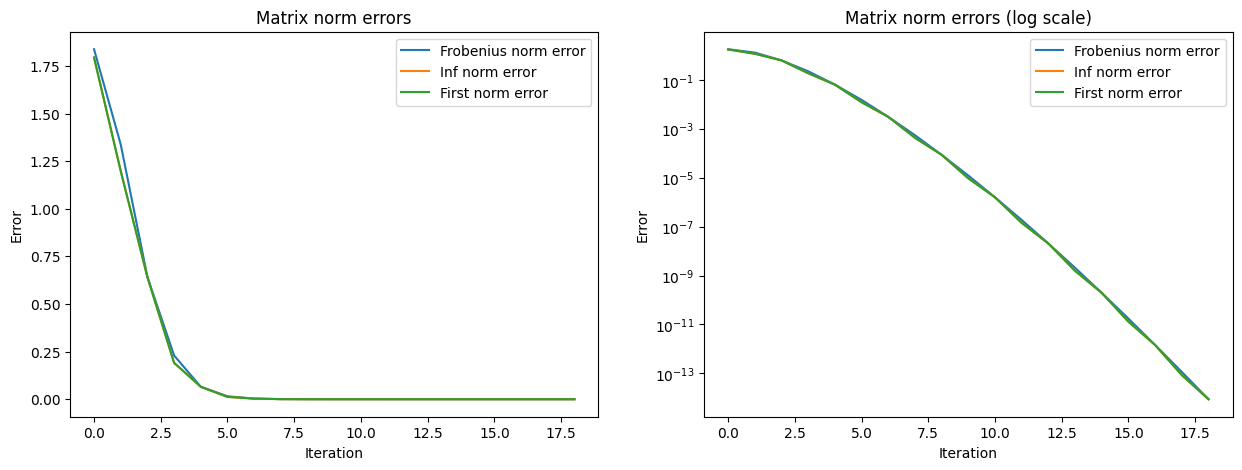

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1) # type: ignore
plt.plot(first_eigenvalue_error, label='1st eigenvalue error')
plt.plot(second_eigenvalue_error, label='2nd eigenvalue error')
plt.title('Eigenvalue errors')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')

fig.add_subplot(1, 2, 2) # type: ignore
plt.plot(first_eigenvalue_error, label='1st eigenvalue error')
plt.plot(second_eigenvalue_error, label='2nd eigenvalue error')
plt.title('Eigenvalue errors (log scale)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1) # type: ignore
plt.plot(fro_norm_error, label='Frobenius norm error')
plt.plot(inf_norm_error, label='Inf norm error')
plt.plot(first_norm_error, label='First norm error')
plt.legend()
plt.title('Matrix norm errors')
plt.xlabel('Iteration')
plt.ylabel('Error')

fig.add_subplot(1, 2, 2) # type: ignore
plt.plot(fro_norm_error, label='Frobenius norm error')
plt.plot(inf_norm_error, label='Inf norm error')
plt.plot(first_norm_error, label='First norm error')
plt.yscale('log')
plt.legend()
plt.title('Matrix norm errors (log scale)')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()